# In-Class Assignment: SVMs continued
# Day 18
# CMSE 202

### <p style="text-align: right;"> &#9989; **Put your name here** </p> Christian Anovert
#### <p style="text-align: right;"> &#9989; Put your group member names here</p> Han Navid Dawit

<img src="https://www.researchgate.net/profile/Trong-Ton-Pham/publication/281602651/figure/fig12/AS:284558864994317@1444855528796/Example-of-Radial-Basis-Function-RBF-kernel-mapping-data-from-non-linear-separable.png" width=500px>

### Agenda for today's class

1. [Preview of pre-class assignment](#pca)
2. [Non-linear SVM: separating data that isn't linearly separable](#non-linear)
3. [Finding the "special" dimension to separate the data](#special)
4. [Example with the "digits" dataset](#digits)
5. [Face recognition](#faces)
   
### Imports:

In [1]:
# imports for the day
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_lfw_people
import time
from sklearn.datasets import make_circles
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split

---
<a id="pca"></a>
## 1. Review of Pre-Class assignment

We'll discussion any questions that came up as a class.

#### Check in with your group

&#9989; **Do This:** Compare the solutions you came up with for separating your 2D "circles" data by transforming the data into a third dimension. Did you come up with similar solutions? Substantially different solutions? Record any important notes from your discussion.

<font size=+3>&#9998;</font> There was no simple outcome that came out of the group members and some had different methods on how to separate the classes when adding more dimensions

---
<a id="non-linear"></a>
## 2. Nonlinear SVM: separating data that isn't linearly separable

Hopefully, if you played with the data a bit or looked around on the web, you were able to find a third dimension that would have made separability of the circle data possible.

To confirm that this is possible, let's set the new Z coordinate to:

$$ Z = X^{2} + Y^{2} $$

for all the data in $X$ and $Y$. If you do this with `numpy` array math, it is a single line of code (no loop required).

&#9989; **Do This:** Make a 2D circle data set, add the specified Z coordinate and plot it below.

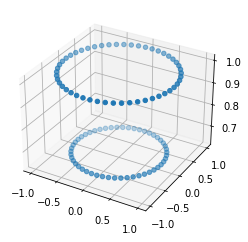

In [35]:
# put your answer here
x,y = make_circles(random_state = 2)



ax = plt.axes(projection = "3d")

z = np.array(x[:,0]**2 + x[:,1]**2)

ax.scatter3D(x[:,0],x[:,1],z)




### 2.1 Running an SVM on the modified data set

Note that we have not added any data to our circle data, we simply created a new dimension **based** on the existing data. In so doing it seems fairly obvious that we can now separate that data. 

&#9989; **Question:** If we were to run an SVM on this modified data, is the data linearly separable? What dimensionality would the separating element have?

<font size=+3>&#9998;</font> Yes these two classes can be separated linearly in which it would be represented as a 2d plane.

----
<a id="special"></a>
## 3. How to find that "special" dimension

It seems like we just pulled that special Z dimension out of thin air. How is it possible to find such a dimension that might make non-linear data linearly separable? That is something an SVM is designed to do! 

The math needed to do this is beyond the scope of this course. But, here is the basic idea:
- we need to define a function $\phi$ that transforms the existing data into a new feature space (a function based on the existing values to generate the new dimension) that would allow us to do better separation.
   - we train and test in that new space, the result of applying $\phi$ into the feature space
- there is a process called <a href="https://en.wikipedia.org/wiki/Kernel_method"> the kernel trick </a> 
    - The kernel trick avoids the explicit mapping that is needed to get linear learning algorithms to learn a nonlinear function or decision boundary. You learned a little about that at the end of the pre-class.
    
Wikipedia describes the following way (which can take a bit of thought to parse!):

> Kernel methods can be thought of as instance-based learners: rather than learning some fixed set of parameters corresponding to the features of their inputs, they instead "remember" the  i-th training example $( x_i , y_i ) $ and learn for it a corresponding weight $w_i$. Prediction for unlabeled inputs, i.e., those not in the training set, is treated by the application of a similarity function **k**, called a kernel, between the unlabeled input $x ′$ and each of the training inputs $x_i$

As you saw in the pre-class, one such useful "kernel" is called the "radial basis function", which mathematically looks like:
$$ k(x^{i}, x^{j}) = exp( -\frac {\| x^{i} -x^{j}\|^{2}} {2\sigma^{2}}) $$
where
$$ \gamma = \frac{1}{2\sigma} $$ 
making
$$ k(x^{i}, x^{j}) = exp(-\gamma \|x^{i} - x^{j} \| ^{2}) $$
and $\gamma$ is a parameter to be optimized (like `C` in the linear case we looked at before).

----
<a id="digits"></a>
## 4. Example using the digits dataset

Let's start with downloading a dataset called "digits" which is included in the sklearn library. That's right, `sklearn` comes with datasets all ready for us to use!

In [36]:
sk_data = load_digits();

Using the ipywidgets module, we can actually create an interactive slider that allows us to flip through all the images.

**Note**: if you're running this notebook inside of Jupyter Lab rather than on the JupyterHub or inside a standard Jupyter Notebook, the interactive slider may not work. For today, if you've been using Jupyter Lab and a slider doesn't show up when you run the code, you'll want to switch over to a regular notebook.

In [37]:
#Cool slider to browse all of the images.
from ipywidgets import interact
def browse_images(images, labels, categories):
    n = len(images)
    def view_image(i):
        plt.imshow(images[i], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('%s' % categories[labels[i]])
        plt.axis('off')
        plt.show()
    interact(view_image, i=(0,n-1))

In [38]:
browse_images(sk_data.images, sk_data.target, sk_data.target_names)

interactive(children=(IntSlider(value=898, description='i', max=1796), Output()), _dom_classes=('widget-intera…


### 4.1 Getting the data

The `sklearn` data comes in a particular format we need to work with. Take a look at <a href="https://scikit-learn.org/stable/datasets.html"> https://scikit-learn.org/stable/datasets.html</a> for a quick overview.

Now let's inspect the digits arrays to find out what the shapes of the arrays (which can help for plotting the data with matplotlib). 

**Review the code below and make sure you know what it is doing.**

In [39]:
feature_vectors = sk_data.data
class_labels = sk_data.target
categories = sk_data.target_names

n_samples, n_features = feature_vectors.shape
N, h, w = sk_data.images.shape
n_classes = len(categories)

&#9989; **Question**: Write some code to print out the number of samples, number of features, number of classes, and the shape of the image dimensions:

In [47]:
#Put your answer to the above question here
print(n_samples)
print(n_features)
print(n_classes)
print(N)
print(h)
print(w)

1797
64
10
1797
8
8


&#9989; **Question**: As a group discuss the difference between the features, samples, and classes.  How do these relate to the shape of the image?  Write down a quick definition of each (the first one has been done for you):

 <font size=+3>&#9998;</font> Do This - Erase this first line of this cell and finish describing variables. Use appropriate markdown to make your answer readable. (double-click on this text to edit this cell, and hit shift+enter to save the text)
 
 
1. **n_samples:** Total number of images in the digits dataset. 
2. **n_features:** features would be the total amount of pixels that will be in eachimage
3. **n_classes:** This is the amount of different outcomes that are present for this set of samples
4. **N:** Is the amount of numbers 
5. **h:** height of the image which is 8 pixels
6. **w:** length of the inmage which is. 8 pixels


### 4.2 Distribution of classes in our data

Let's have a look at the distribution of samples across the target classes:

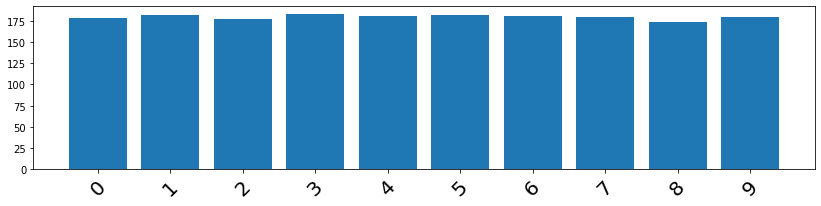

In [48]:
plt.figure(figsize=(14, 3))

y_unique = np.unique(class_labels)
counts = [(class_labels == i).sum() for i in y_unique]

plt.xticks(y_unique,  categories[y_unique])
locs, labels = plt.xticks()
plt.setp(labels, rotation=45, size=20)
_ = plt.bar(y_unique, counts)

&#9989; **Question**: Does this seem like a good set of samples for training our machine learning algorithm? Why?

 <font size=+3>&#9998;</font>Yes, there's an equal amount of samples for each class and splitting it won't be biased

### 4.3 Train a SVM Classifier based on the training dataset.

Let's split the data into a training set and final testing set as we have done in the past.

We've used `train_test_split` before so do it here now. To stay in sync with the code below, create:
- `train_vectors` and `train_labels` for the training feature vectors and corresponding class labels
- `test_vectors` and `test_labels` for the test feature vectors and labels. 

Do that below:

In [55]:
# put your answer here
train_vectors, test_vectors, train_labels, test_labels = train_test_split(feature_vectors,class_labels,test_size = .2)
                                                                       
                                                                    



## 4.4 Optimizing hyper-parameters

There are two parameters we might try to optimize to get better results:
- the C parameter of SVM. We discussed this in the previous in-class assignment
- the $\gamma$ parameter of rbf (our radial basis function kernel)

These tuning parameters are often called **hyper-parameters**. These are parameters that affect the algorithm's "learning" process.

### 4.4.1 The C parameter

Here's another way to describe `C`. There are two types of SVM classifiers: hard margin and soft margin. Most SVM implementations are soft margin because "soft" allows for some points to be mis-classified when defining the margin (hard margin does not). The **C** parameter of the `svm.SVC` helps in choosing how "soft" to allow the margin to be:
- small values of C allow for some point misclassification but lower the effect of noisy outliers
- larger values of C push to accomodate even noisy points in favor of higher efficiency

### 4.4.2 The $\gamma$ parameter
The $\gamma$ value is part of the rbf (radial basis function). When thinking about the influence of $\gamma$, it can be useful to think about it this way:

* A small gamma value defines a Gaussian function with a large variance. In the case of a small gamma value, two points can be considered similar even if are far from each other.
* On the other hand, a large gamma value defines a Gaussian function with a small variance and for this case, two points are considered similar just if they are close to each other. 

### 4.4.3 `GridSearchCV` and choosing hyper-parameters
It can be difficult to search for an optimal combination of a set of hyper-parameters. What is the best combination of $C$ and $\gamma$ for our digits data set? One way to avoid the issue is to test combinations of a fixed set of each hyper-parameter and evaluate which combinations are optimal. In this way we trade time (time to do all the testing) for better results.

In the code below we use the import of <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html"> `GridSearchCV` </a> from `sklearn.model.selection` (done in the cell at the top of the notebook).

The idea behind GridSearchCV is pretty simple:
- provide a list of hyper-parameters and, for each hyper-parameter, a set of values you which to test.
- `GridSearchCV` will **exhaustively** search, that is will try **all combinations** of the listed parameters, and based on the **best combination** will return results.

The above terms **exhautively** and **all combinations** are a kind of warning. These mean that considerable computational effort might be required to evaluate which hyper-parameter combinations is "best".

**How many different $C$ and $\gamma$ values does the code below explore?**

#### How long will it take?
You might need to be patient. On a decent desktop computer, 20-30 seconds, on a lightweight laptop, code might take more like a minute or two. It might take longer depending on what you are using!

### 4.5 Training the classification model

In [56]:
###############################################################################
# Train a SVM classification model

start = time.time()

#make some temporary variables so you can change this easily
tmp_vectors = train_vectors
tmp_labels = train_labels

print("Fitting the classifier to the training set")
# a dictionary of hyperparameters: key is the name of the parameter, value is a list of values to test
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
              'kernel': ['linear','rbf']}
# make a classifier by searching over a classifier and the parameter grid
clf = GridSearchCV(SVC(class_weight='balanced'), param_grid)

# we have a "good" classifier (according to GridSearchCV), how's it look
clf = clf.fit(tmp_vectors, tmp_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print("Best parameters found by grid search:")
print(clf.best_params_)

end = time.time()
print("Runtime",end - start)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0005)
Best parameters found by grid search:
{'C': 1000.0, 'gamma': 0.0005, 'kernel': 'rbf'}
Runtime 19.587376594543457


&#9989; **Question**: What parameter values did the grid search decide were the best ones? Which kernel?

<font size=+3>&#9998;</font> C = 1000, gamma = .0005 and uses a rbf model

&#9989; **Do this**: Explore the ```clf``` object created in the code above using some of the Python exploration commands we've used in the past (e.g. `dir`, `help`, `?`). What functions does it have access to?  Can you figure out what function you may use to input a unknown feature vector and make a class prediction?

In [58]:
## DO THIS, put your exploration code here.
dir(clf)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_is_fitted',
 '_check_n_features',
 '_check_refit_for_multimetric',
 '_estimator_type',
 '_format_results',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_pairwise',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_run_search',
 '_validate_data',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'fit',
 'get_params',
 'inverse_transform',
 'multimetric_',
 'n_features_in_',
 'n_jobs',
 'n_splits

### 4.6. Reviewing the results of the classification on the testing dataset.

We can use our new classifier to predict values using the testing vectors we created earlier and compare them to the known labels to see how well our classifier is doing.

&#9989; **Do This**: Run the code below and take some time to process the output. Do you understand what all of the provided information is telling you?

In [59]:
###############################################################################
# Quantitative evaluation of the model quality on the test set

#make some temporary variables so you can change this easily
predict_vectors = test_vectors
true_labels = test_labels

print("Predicting names on the test set")
pred_labels = clf.predict(predict_vectors)

print(classification_report(true_labels, pred_labels))
print(confusion_matrix(true_labels, pred_labels, labels=range(n_classes)))


Predicting names on the test set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       0.98      1.00      0.99        47
           2       0.97      1.00      0.99        36
           3       1.00      0.95      0.98        43
           4       1.00      1.00      1.00        34
           5       1.00      0.97      0.98        33
           6       1.00      1.00      1.00        32
           7       0.97      1.00      0.99        33
           8       1.00      0.96      0.98        28
           9       0.98      1.00      0.99        40

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360

[[34  0  0  0  0  0  0  0  0  0]
 [ 0 47  0  0  0  0  0  0  0  0]
 [ 0  0 36  0  0  0  0  0  0  0]
 [ 0  0  1 41  0  0  0  1  0  0]
 [ 0  0  0  0 34  0  0  0  0  0]
 [ 0  0  0  0  0 32  0  0  0  1]
 [ 0  0  0

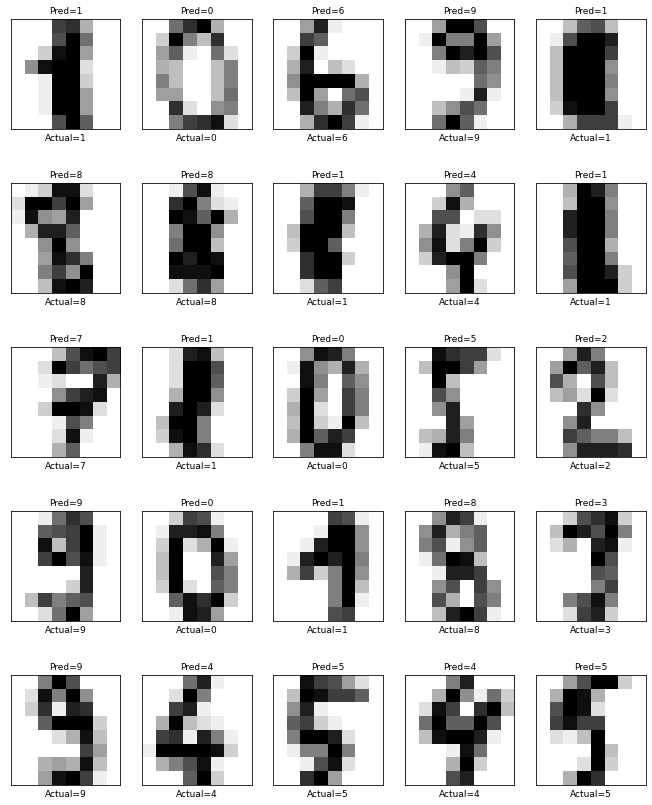

In [60]:
def plot_gallery(images, true_titles, pred_titles, h, w, n_row=5, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray_r)
        plt.title('Pred='+str(categories[pred_titles[i]]), size=9)
        plt.xlabel('Actual='+str(categories[true_titles[i]]), size=9)
        plt.xticks(())
        plt.yticks(())

plot_gallery(test_vectors, test_labels, pred_labels, h,w)

&#9989; **Question:** How well is the classifier doing with the digits dataset? Comment on what information the classification report provides you and define the following terms:

* Precision
* Recall
* F1 Score

You might need to do a big of digging in the sklearn documentation or do a bit of google-searching.

<font size=+3>&#9998;</font> Precision is the accuracy of the positive predictions and recall measures the completeiveness of the positive predictions. THe F1 score measures the overall accuracy of the mode

&#9989; **Question:** What information does the confusion matrix provides you with? What do numbers on the diagonal represent? What about values above and below the diagonal? Discuss this with your group!

<font size=+3>&#9998;</font> The values on the diagonal represent how many images were correct at a class and the numbers above or below the diagonal show where the model thought it was one class but was actually defined as another class

&#9989; **Questions:** What if you created a new random training set from the images using the same fraction of images? What if you just used all of the data -- does it work better or worse? Why? You may want to experiment a bit with this!

<font size=+3>&#9998;</font> It would work better because with more data, it will make the model predict better for the images.

---
<a id="faces"></a>
## 5. Face Recognition

Now that we have completed the example for digits dataset. Lets do it again with some faces. Fortunately, scikit-learn comes with a face dataset in exactly the same format as the digits dataset.  This means we should just be able to swap out one with the other. Here is the code for importing the faces data.  This code ensures there are at least 50 faces per person and they are resized to 40%.  

```sk_data = fetch_lfw_people(min_faces_per_person=50, resize=0.4)```

You may need to double-check that the import for `fetch_lfw_people` is in the code cell at the top of the notebook.

&#9989; **Do this**:  Repeat the entire process using the face database imported with the command shown above. Answer the following questions.

**Note**: you should not need to update any of the provided code as it all hinges on `sk_data`, **but to save time, you should only try using the `linear` kernel and skip the `rbf` kernel for now.** (testing the rbf kernel takes longer)

In [62]:
# copy the code above and paste it after the modified dataset provided here

sk_data = fetch_lfw_people(min_faces_per_person=50, resize=0.4)



0.09902238845825195


In [70]:
feature_vectors = sk_data.data
class_labels = sk_data.target
categories = sk_data.target_names

n_samples, n_features = feature_vectors.shape
N, h, w = sk_data.images.shape
n_classes = len(categories)

train_vectors, test_vectors, train_labels, test_labels = train_test_split(feature_vectors,class_labels,test_size = .2)
        
###############################################################################
# Train a SVM classification model

start = time.time()

#make some temporary variables so you can change this easily
tmp_vectors = train_vectors
tmp_labels = train_labels

print("Fitting the classifier to the training set")
# a dictionary of hyperparameters: key is the name of the parameter, value is a list of values to test
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
              'kernel': ['linear','rbf']}
# make a classifier by searching over a classifier and the parameter grid
clf = GridSearchCV(SVC(class_weight='balanced'), param_grid)

# we have a "good" classifier (according to GridSearchCV), how's it look
clf = clf.fit(tmp_vectors, tmp_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print("Best parameters found by grid search:")
print(clf.best_params_)

end = time.time()
print("Runtime",end - start)  





Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0001, kernel='linear')
Best parameters found by grid search:
{'C': 1000.0, 'gamma': 0.0001, 'kernel': 'linear'}
Runtime 266.1116316318512


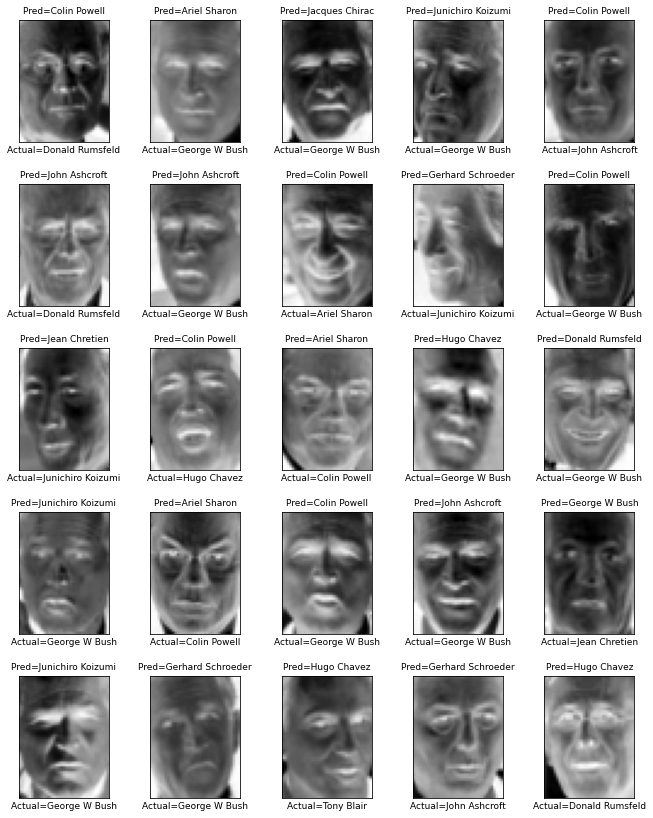

In [71]:
def plot_gallery(images, true_titles, pred_titles, h, w, n_row=5, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray_r)
        plt.title('Pred='+str(categories[pred_titles[i]]), size=9)
        plt.xlabel('Actual='+str(categories[true_titles[i]]), size=9)
        plt.xticks(())
        plt.yticks(())

plot_gallery(test_vectors, test_labels, pred_labels, h,w)

In [72]:
###############################################################################
# Quantitative evaluation of the model quality on the test set

#make some temporary variables so you can change this easily
predict_vectors = test_vectors
true_labels = test_labels

print("Predicting names on the test set")
pred_labels = clf.predict(predict_vectors)

print(classification_report(true_labels, pred_labels))
print(confusion_matrix(true_labels, pred_labels, labels=range(n_classes)))

Predicting names on the test set
              precision    recall  f1-score   support

           0       0.73      0.79      0.76        14
           1       0.79      0.73      0.76        45
           2       0.83      0.83      0.83        23
           3       0.88      0.91      0.89       119
           4       0.82      0.82      0.82        17
           5       0.85      0.85      0.85        13
           6       0.78      0.88      0.82         8
           7       0.83      0.91      0.87        11
           8       0.86      0.67      0.75         9
           9       0.82      1.00      0.90         9
          10       0.78      0.78      0.78         9
          11       0.81      0.71      0.76        35

    accuracy                           0.83       312
   macro avg       0.81      0.82      0.82       312
weighted avg       0.83      0.83      0.83       312

[[ 11   2   0   0   0   0   0   0   0   0   0   1]
 [  2  33   0   3   0   0   0   1   1   0   1   4

&#9989; **Question:** How long did it take to train the face recognition classifier?

<font size=+3>&#9998;</font> .099 seconds266 seconds

&#9989; **Question:** How well did the SVM algorithm work on the face recognition problem?  Can you think of real world applications where this level of face recognition may be acceptable?

<font size=+3>&#9998;</font> Not that great only around 76%

&#9989; **Question:** Why might the classifier be struggling to classify the faces compared to the digits? Which face(s) does it seem to be the most accurate at classifying? Why might that be?

<font size=+3>&#9998;</font> The coloration of the images are very poor

&#9989; **Question:** Can you think of some other example problems where this type of machine learning classification (SVM) in general may be used?

<font size=+3>&#9998;</font> For looking at clear image classification

In [69]:
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://cmse.msu.edu/cmse202-ic-survey" 
	width="800px" 
	height="600px" 
	frameborder="0" 
	marginheight="0" 
	marginwidth="0">
	Loading...
</iframe>
"""
)

-----
### Congratulations, we're done!

Now, you just need to submit this assignment by uploading it to the course <a href="https://d2l.msu.edu/">Desire2Learn</a> web page for today's submission folder (Don't forget to add your names in the first cell).


&#169; Copyright Michigan State University Board of Trustees